In [14]:
import cvxpy as cp
import numpy as np

In [15]:
S = np.matrix('1 -0.5 ;-0.5, 2')
print(S.shape)
A = np.matrix('1 -2 ; 1  4; 5 -76 ')
print(A.shape)
b = np.matrix('-2 -3 1').T
extra = np.matrix('-1 0').T
print(extra.shape)
print(b.shape)

(2, 2)
(3, 2)
(2, 1)
(3, 1)


### $\text{(a) The primal}$

---

Every term in the objective is Quadratic except the last one. This hints an approach using Quadratic forms.
Let 
\begin{align}
        \vec{x}  =  
        \begin{bmatrix} 
        x_1 \\
        x_2
        \end{bmatrix}
\end{align}
Although several quadratic forms may fit this description, we choose a $\textbf{Symmetric}$ one
\begin{align}
    \min \ x_1^2 + 2x_2^2 + x_1x_2 - x_1  = \ 
    \begin{bmatrix} 
        x_1 \\
        x_2
    \end{bmatrix}^T
    \begin{bmatrix}
    1 & -0.5 \\
    -0.5 & 1 
    \end{bmatrix}
    \begin{bmatrix} 
        x_1 \\
        x_2
    \end{bmatrix}
     + [-1 \  \ 0]^Tx
     = \vec{x}^T S \vec{x} + e^T\vec{x}
\end{align}

$ \text{Since rest of the constraints are affine and } S \in  \mathbb{S}_{n}^{++}$ $\text{, This is a QP}$

In [16]:
x = cp.Variable((2,1))
objective = cp.Minimize(cp.quad_form(x,S) + extra.T@x)
constraints = [A@x <= b]
problem = cp.Problem(objective,constraints)
p_star = problem.solve()
print("result of the primal = ",p_star)


result of the primal =  7.444444444444442


In [17]:
print("optimal x = ", x.value)
x_star = x.value
print(x_star.shape)

optimal x =  [[-2.33333333]
 [-0.16666667]]
(2, 1)


In [18]:
print(type(S))
print(type(A))
print(type(x_star))
x_star = np.asmatrix(x_star)
print(type(x_star)) #type checking to prevent errors 

<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.ndarray'>
<class 'numpy.matrix'>


### $\text{(b) The Dual}$

---
The lagrangian is given by adding the polyhedra constraints
\begin{align}
    L(x,\lambda) = x^tSx + e^Tx + \lambda^T(Ax - b)  = \text{Convex as S$\ge$ 0}
    \\
    \nabla_{x} L(x^*,\lambda) = 0 \ \ \ (\text{Forcing KKT condition})
    \\
\end{align}
Solving the second equation gives,
\begin{align}
    x^* = -\frac{1}{2}S^{-1}(A^T\lambda + e)
\end{align}

Now we substitute the value of $x^*$ in (3) into the lagrangian to get a pure function of $\lambda$.


This function is the dual objective $g(\lambda)$ we should now solve for the maximum value of this function, assuming $\lambda \ge 0 $ and (3) holds

In [19]:

lambda_star = cp.Variable((3,1))
objective_dual = cp.Maximize(-0.25*(cp.quad_form((A.T@lambda_star + extra),np.linalg.inv(S.T)) ) -0.5*extra.T@(np.linalg.inv(S)@(A.T@lambda_star + extra)) )
constraints_dual= [A.T@lambda_star + extra + 2*S@x_star == 0,lambda_star >=0,lambda_star[2][0] ==0]
prob = cp.Problem(objective_dual,constraints_dual)
result = prob.solve()
dual_vars = lambda_star.value
print(dual_vars)



[[3.94444444e+00]
 [1.55555556e+00]
 [3.79729124e-23]]


### $\text{(b) Dual Values}$

----


When you solve this system (without the extra constraint of $\lambda_{3} = 0$ you will get dual variables which are  non - zero for the third constraint!.
This is a problem that arises because of the iterative methods that CVXPY uses to solve the problems (if you continue without this your dual varaibles will not match up with the rate of change of the optimal value when perturbing)).

\begin{align}
\vec{\lambda} = 
\begin{bmatrix}
3.944 \\
1.555 \\
0.000 \\
\end{bmatrix}
\end{align}


In [35]:
#to solve for dual Variables ;
K = A@x_star
print()
print("x is feasible ? ,AX - b = \n",K - b)
print("Gradient = \n",(A.T@lambda_star.value + extra + 2*S@x_star))
print("Slackness = \n",lambda_star.value.T @ (A@x_star - b))
print("lambda feasible ? \n",lambda_star.value >= 0)

#nearly all of the slackness condidtions are satisified , so dual variables may be  non zero


x is feasible ? ,AX - b = 
 [[4.4408921e-16]
 [0.0000000e+00]
 [4.4408921e-15]]
Gradient = 
 [[0.0000000e+00]
 [8.8817842e-16]]
Slackness = 
 [[1.75168522e-15]]
lambda feasible ? 
 [[ True]
 [ True]
 [ True]]


### $\text{(e) KKT Conditions}$

---

As you can see from the code above, all the KKT conditions are holding, Moreover our problem is convex , therefore Strong duality will hold.

In [59]:

h = 0.08
u1_min, u1_max = -5, -2
u2_min, u2_max = -5 ,-2
print(u2_min, u2_max)
print(u1_min,u1_max)
xx, yy = np.meshgrid(np.arange(u1_min, u1_max, h),
                     np.arange(u1_min, u2_max, h))

-5 -2
-5 -2


In [60]:
def Calculate_optima(u1,u2):
    b_new = np.matrix([[u1 ,u2, 1]]).T
    x = cp.Variable((2,1))
    objective = cp.Minimize(cp.quad_form(x,S) + extra.T@x)
    constraints = [A@x <= b_new]
    problem = cp.Problem(objective,constraints)
    p_star = problem.solve()
    return p_star

In [61]:
p_star_vals = np.ones(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        p_star_vals[i][j] = Calculate_optima(xx[i][j],yy[i][j])
        

In [62]:
np.linalg.eigvals(S)
print(dual_vars.T @(A@x_star - b))

[[1.75168522e-15]]


### $ (d),(e)\text{Plotting Level Curves, Convexity of p(u1,u2) } $

---

The level curves will be of the form below, this obtained by repeatedly solving for all the possible values of optimal in the plane. $p^*$ can be obtained by also imposing slackness and substituting the values of u1 and u2 into the value of p.

\begin{align}
 x^*_{1} - 2x^*_2 = u_1
 \\
 x^*_{1} + 4x^*_2 = u_2
 \\
 p^* = x_1^2 + 2x_2^2 + x_1x_2 - x_1 
 \\
 \text{Substituting values of $x_1^*$ and $x_2^*$ into p}
 \\
 p^* = \frac{1}{18} \times (11u_1^2 + 5u_1u_2 + 2u_2^2 - 12u_1 - 6u_2)
 \\
 p^* = \frac{1}{18} ( u^T 
 \begin{bmatrix}
  11 & 2.5 \\
  2.5 & 2 \\
 \end{bmatrix}
 u + [12  \ -6]^T u)
 p^* = \text{Quadratic with +ve Semidefinite Matrix = Convex}
\end{align}



(38, 38)


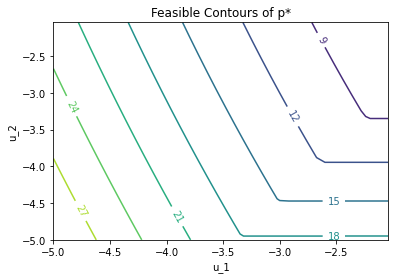

In [63]:
print(p_star_vals.shape)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
level_curves = ax.contour(xx,yy,p_star_vals)
ax.set_xlabel("u_1")
ax.set_ylabel("u_2")
ax.set_title("Feasible Contours of p*")
ax.clabel(level_curves,inline = True, fontsize = 10)
plt.show()

In [64]:
#say i now ignore feasibility and just plot the function which we obtained above 
h = 0.08
u1_min_,u1_max = -5, +5
u2_min, u2_max = -5 ,+5
print(u2_min, u2_max)
print(u1_min,u1_max)
xx, yy = np.meshgrid(np.arange(u1_min, u1_max, h),
                     np.arange(u1_min, u2_max, h))


-5 5
-5 5


In [65]:
def elliptic(u1 ,u2):
    return (11*u1**2  + 5*u1*u2 + 2* u2**2  - 12*u1 - 6*u2)/18


In [66]:
p_star_new_vals = np.ones(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        p_star_new_vals[i][j] = elliptic(xx[i][j] , yy[i][j])
print(p_star_new_vals.shape)


(125, 125)


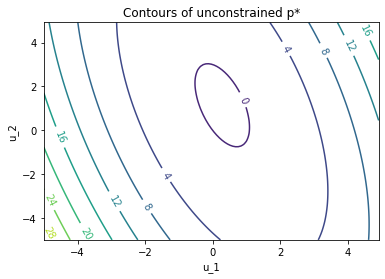

In [50]:
fig,ax = plt.subplots()
level_curves = ax.contour(xx,yy,p_star_new_vals)
ax.set_xlabel("u_1")
ax.set_ylabel("u_2")
ax.set_title("Contours of unconstrained p*")
ax.clabel(level_curves,inline = True, fontsize = 10)
plt.show()

### $\text{(f) Perturbation}$

---

The code below changes the values by 0.008 (local to 2 and 3) and then we measure the change in the optimal value clearly they match ! 
\begin{align}
        \nabla p(u_1,u_2) = 
        \begin{bmatrix}
        -\lambda_1 \\
        -\lambda_2
        \end{bmatrix}
\end{align} 

In [26]:
#let us calculate numerical gradient near u1 = -2 and u2 = -3
dpdu1 = (Calculate_optima(-2.079 + 0.08, -3) - Calculate_optima(-2.079, -3))/(0.08) #small perturbation to avoid the flattening at the end of the level curve
dpdu2 = (Calculate_optima(-2, -3 + 0.08) - Calculate_optima(-2 , -3))/(0.08)
lambda_1 = dual_vars[0][0]
lambda_2 = dual_vars[1][0]
print(Calculate_optima(-2,-3))
print("dpdu1 = ",dpdu1)
print("dpdu2 = ",dpdu2)
print("lambda 1 = ",lambda_1)
print("lambda 2 = ",lambda_2)


7.444444444444442
dpdu1 =  -3.9428131944444833
dpdu2 =  -1.5466666666666296
lambda 1 =  3.9444444444444438
lambda 2 =  1.5555555555555556
